# Loop calling and differential loop analysis

In [1]:
import os
import importlib
import numpy as np
import pandas as pd
from scipy import stats
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

from utils.data import DataTree
import snapfish2 as sf
importlib.reload(sf)

<module 'snapfish2' from '/Users/redfishhh/Documents/research/MultiplexedFISH/LoopTests/snapfish2/__init__.py'>

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
out_dire = "../123ACElog/032125"
dtree = DataTree("../data")

## Loop calling on merged data from two replicates

In [4]:
loader = sf.pp.FOF_CT_Loader({
    "rep1": dtree["takei_nature_2021", "25Kb", "rep1"],
    "rep2": dtree["takei_nature_2021", "25Kb", "rep2"]
}, voxel_ratio={"X": 103, "Y": 103, "Z": 250})

In [5]:
res_sf1_path = os.path.join(out_dire, "loop_result_sf1.csv")
if not os.path.exists(res_sf1_path):
    loop = sf.tl.LoopCaller(pval_cutoff=1, gap=50e3, ltclass=sf.tl.TwoSampleT)
    sf.wr.caller_wrapper(loader, loop=loop, loop_path=res_sf1_path)
res_sf1 = pd.read_csv(res_sf1_path, sep="\t")
res_sf2_path = os.path.join(out_dire, "loop_result_sf2.csv")
if not os.path.exists(res_sf2_path):
    loop = sf.tl.LoopCaller(gap=50e3, ltclass=sf.tl.AxisWiseF)
    sf.wr.caller_wrapper(loader, loop=loop, loop_path=res_sf2_path)
res_sf2 = pd.read_csv(res_sf2_path, sep="\t")

In [6]:
noised_path = {
    "rep1": os.path.join(out_dire, "takei_nature_25kb_rep1.csv"),
    "rep2": os.path.join(out_dire, "takei_nature_25kb_rep2.csv")
}
from utils.data import add_noise
noise = {"X": 0, "Y": 0, "Z": 50}
ratio = {"X": 103, "Y": 103, "Z": 250}
np.random.seed(0)
add_noise(loader.path, ratio, noised_path, noise)
noised_loader = sf.pp.FOF_CT_Loader(noised_path, voxel_ratio=ratio)

In [7]:
res_sf1_noised_path = os.path.join(out_dire, "loop_result_sf1_noised.csv")
if not os.path.exists(res_sf1_noised_path):
    loop = sf.tl.LoopCaller(pval_cutoff=1, gap=50e3, ltclass=sf.tl.TwoSampleT)
    sf.wr.caller_wrapper(noised_loader, loop=loop, loop_path=res_sf1_noised_path)
res_sf1_noised = pd.read_csv(res_sf1_noised_path, sep="\t")
res_sf2_noised_path = os.path.join(out_dire, "loop_result_sf2_noised.csv")
if not os.path.exists(res_sf2_noised_path):
    loop = sf.tl.LoopCaller(gap=50e3, ltclass=sf.tl.AxisWiseF)
    sf.wr.caller_wrapper(noised_loader, loop=loop, loop_path=res_sf2_noised_path)
res_sf2_noised = pd.read_csv(res_sf2_noised_path, sep="\t")

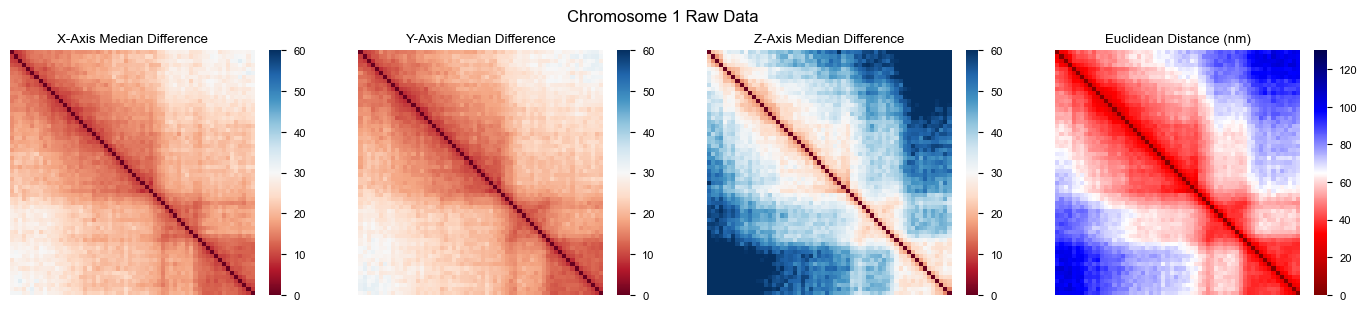

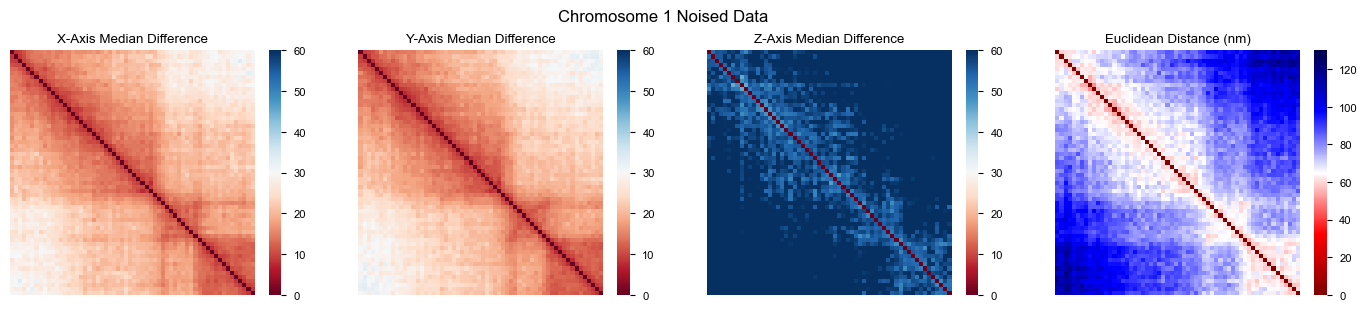

In [8]:
from utils.maps import dist_diff_heatmaps
chr_id = "chr1"
adata_raw = loader.create_adata(chr_id)
fig, axes = plt.subplots(1, 4, figsize=(14, 3))
dist_diff_heatmaps(axes, adata_raw, 60, 130)
fig.suptitle(f"Chromosome {chr_id[3:]} Raw Data")
fig.savefig(os.path.join(out_dire, "s4a_median_hm_raw.pdf"), bbox_inches="tight")

adata_noised = noised_loader.create_adata(chr_id)
fig, axes = plt.subplots(1, 4, figsize=(14, 3))
dist_diff_heatmaps(axes, adata_noised, 60, 130)
fig.suptitle(f"Chromosome {chr_id[3:]} Noised Data")
fig.savefig(os.path.join(out_dire, "s4b_median_hm_noi.pdf"), bbox_inches="tight")

## Using the noise-free as the ground truth

In [9]:
from matplotlib_venn import venn2
from utils.maps import venn_subsets

subsets1 = venn_subsets(res_sf1, res_sf1_noised)
subsets2 = venn_subsets(res_sf2, res_sf2_noised)

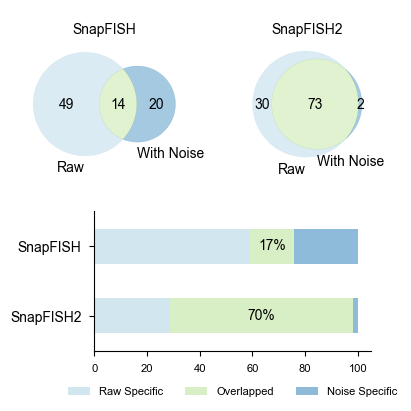

In [10]:
colors = sns.color_palette("Paired", 10)[0:3]
fig = plt.figure(figsize=(4, 4))
sfigs = fig.subfigures(2, 1)

axes = sfigs[0].subplots(1, 2)
v1 = venn2(subsets=subsets1, set_labels=("Raw", "With Noise"), ax=axes[0])
axes[0].set_title("SnapFISH", fontsize=sf.settings.fontsize, y=0.83)
axes[0].set_ylim(-.9, .9)
for text in v1.set_labels:
    text.set_fontsize(sf.settings.fontsize)
v2 = venn2(subsets=subsets2, set_labels=("Raw", "With Noise"), ax=axes[1])
axes[1].set_title("SnapFISH2", fontsize=sf.settings.fontsize, y=0.83)
axes[1].set_ylim(-1, 1)
for text in v2.set_labels:
    text.set_fontsize(sf.settings.fontsize)
for idx, c in zip(["10", "01", "11"], colors):
    v1.get_patch_by_id(idx).set_color(c)
    v2.get_patch_by_id(idx).set_color(c)
    
ax = sfigs[1].subplots()
df = pd.DataFrame({
    "SnapFISH2": np.array(subsets2)/sum(subsets2)*100,
    "SnapFISH": np.array(subsets1)/sum(subsets1)*100
}, index=["Raw Specific", "Noise Specific", "Overlapped"]).T
df = df[["Raw Specific", "Overlapped", "Noise Specific"]]
color = [colors[0], colors[2], colors[1]]
df.plot(kind="barh", stacked=True, color=color, ax=ax, alpha=.5)
ax.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.4),
          fontsize=sf.settings.fontsize*.8)
ax.tick_params(axis="y", labelsize=sf.settings.fontsize, rotation=0)
bar = ax.patches[3]
ax.text(bar.get_x() + bar.get_width() / 2,
        bar.get_y()+.2*(1%2),# + bar.get_height() / 2,
        f"{bar.get_width():.0f}%",
        fontsize=sf.settings.fontsize, rotation=0, ha="center")
bar = ax.patches[2]
ax.text(bar.get_x() + bar.get_width() / 2,
        bar.get_y()+.2*(1%2),# + bar.get_height() / 2,
        f"{bar.get_width():.0f}%",
        fontsize=sf.settings.fontsize, rotation=0, ha="center")
ax.grid(False)
fig.savefig(os.path.join(out_dire, "2a_loop_overlap.pdf"), bbox_inches="tight")

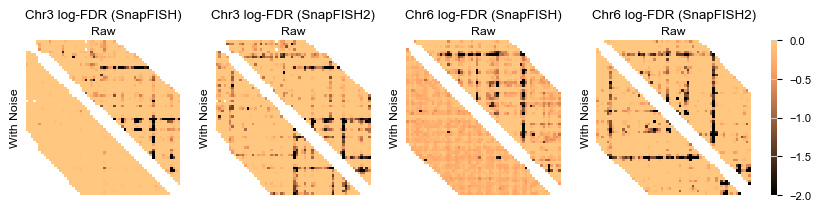

In [11]:
caller1 = sf.tl.LoopCaller(ltclass=sf.tl.TwoSampleT)
caller2 = sf.tl.LoopCaller(ltclass=sf.tl.AxisWiseF)

fig, axes = plt.subplots(1, 5, figsize=(8.1, 2), 
                         width_ratios=[3, 3, 3, 3, .1])
i = 0
for chr_id in ["chr3", "chr6"]:
    adata_raw = loader.create_adata(chr_id)
    res1_raw = caller1.call_loops(adata_raw)
    sf.pp.filter_normalize(adata_raw)
    res2_raw = caller2.call_loops(adata_raw)
    adata_noised = noised_loader.create_adata(chr_id)
    res1_noised = caller1.call_loops(adata_noised)
    sf.pp.filter_normalize(adata_noised)
    res2_noised = caller2.call_loops(adata_noised)
    
    cbar_ticks = [-2, -1.5, -1, -.5, 0]
    sf.pl.pairwise_heatmap(
        X1=np.log(res1_raw["fdr"]), X2=np.log(res1_noised["fdr"]),
        vmax=0, vmin=-2, ax=axes[i+0], x="Raw", y="With Noise",
        title=f"{chr_id.title()} log-FDR (SnapFISH)", cbar_ax=axes[-1],
        cmap="copper", cbar_kws={'ticks': cbar_ticks},
    )
    sf.pl.pairwise_heatmap(
        X1=np.log(res2_raw["fdr"]), X2=np.log(res2_noised["fdr"]),
        vmax=0, vmin=-2, ax=axes[i+1], x="Raw", y="With Noise", cbar=False,
        title=f"{chr_id.title()} log-FDR (SnapFISH2)", cmap="copper"
    )
    i += 2
fig.savefig(os.path.join(out_dire, "s4c_fdr.pdf"), bbox_inches="tight")

In [12]:
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]
df1 = pd.merge(res_sf1, res_sf1_noised, on=cols, how="inner")
df1 = df1.dropna(subset=["fdr_x", "fdr_y"])
df2 = pd.merge(res_sf2, res_sf2_noised, on=cols, how="inner")
df2 = df2.dropna(subset=["fdr_x", "fdr_y"])
corr_df = []
for chr_id in pd.unique(df1["c1"]):
    df = df1[df1["c1"]==chr_id]
    # Remove small p-values that likely cause numerical instability
    df = df[(df["pval_x"] > 1e-10)&(df["pval_y"] > 1e-10)]
    r = stats.pearsonr(df["pval_x"], df["pval_y"])[0]
    corr_df.append([r, "SnapFISH", len(df), chr_id])

    df = df2[df2["c1"]==chr_id]
    # Remove small p-values that likely cause numerical instability
    df = df[(df["pval_x"] > 1e-10)&(df["pval_y"] > 1e-10)]
    r = stats.pearsonr(df["pval_x"], df["pval_y"])[0]
    corr_df.append([r, "SnapFISH2", len(df), chr_id])
corr_df = pd.DataFrame(corr_df, columns=["Pearson", "Method", "N", "Chr"])

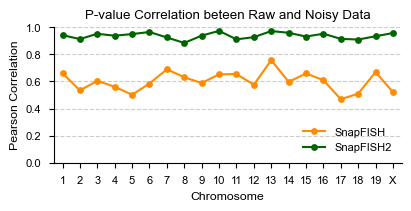

In [13]:
fig, ax = plt.subplots(figsize=(4, 2))
sns.pointplot(data=corr_df, x="Chr", y="Pearson", hue="Method", linewidth=1.5, 
              palette={"SnapFISH":"darkorange", 
                       "SnapFISH2":"darkgreen"}, ax=ax)
ax.set(ylim=(0, 1), title="P-value Correlation beteen Raw and Noisy Data")
ax.set(xlabel="Chromosome", ylabel="Pearson Correlation")
xticklabels = [t[3:] for t in pd.unique(corr_df["Chr"])]
ax.set(xticks=ax.get_xticks(), xticklabels=xticklabels)
ax.legend(loc="lower right")
ax.grid(True, axis="y", linestyle="--")
fig.savefig(os.path.join(out_dire, "s4d_pval_corr.pdf"), bbox_inches="tight")

`python -m pip install igv-notebook`

In [14]:
res_sf1[res_sf1["final"]].iloc[:,:6].to_csv(
    os.path.join(out_dire, "final_summit_s1_raw.bedpe"), index=False, sep="\t"
)
res_sf1_noised[res_sf1_noised["final"]].iloc[:,:6].to_csv(
    os.path.join(out_dire, "final_summit_s1_noi.bedpe"), index=False, sep="\t"
)
res_sf2[res_sf2["final"]].iloc[:,:6].to_csv(
    os.path.join(out_dire, "final_summit_s2_raw.bedpe"), index=False, sep="\t"
)
res_sf2_noised[res_sf2_noised["final"]].iloc[:,:6].to_csv(
    os.path.join(out_dire, "final_summit_s2_noi.bedpe"), index=False, sep="\t"
)

In [ ]:
import igv_notebook
igv_notebook.init()
chr_id = "chr6"
d1df = loader.create_adata(chr_id).var
igv_browser= igv_notebook.Browser({
    "genome": "mm10", 
    "locus":  f"{chr_id}:{d1df.Chrom_Start.min()}-{d1df.Chrom_End.max()}",
    "tracks": [{"name": "SnapFISH (Raw)",
        "url": os.path.join(out_dire, "final_summit_s1_raw.bedpe"),
        "format": "bedpe", "height": 50, "color": "darkorange"
    }, {"name": "SnapFISH2 (Raw)",
        "url": os.path.join(out_dire, "final_summit_s2_raw.bedpe"),
        "format": "bedpe", "height": 50, "color": "darkgreen"
    }, {"name": "SnapFISH (with Noise)",
        "url": os.path.join(out_dire, "final_summit_s1_noi.bedpe"),
        "format": "bedpe", "height": 50, "color": "darkorange"
    }, {"name": "SnapFISH2 (with Noise)",
        "url": os.path.join(out_dire, "final_summit_s2_noi.bedpe"),
        "format": "bedpe", "height": 50, "color": "darkgreen"
    }, {"name": "ChIP-seq CTCF",
        "url": dtree["chipseq_mesc", "CTCF", "bigWig"],
        "format": "bigwig", "height": 50, "color": "blue"
    }]
})

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ChIA-PET

In [15]:
fish_path = dtree["takei_nature_2021", "25Kb", "rep1"]
ctcf_path = dtree["chiapet_mesc", "CTCF", "129S1/SvImJ"]
polr2a_path = dtree["chiapet_mesc", "POLR2A", "129S1/SvImJ"]

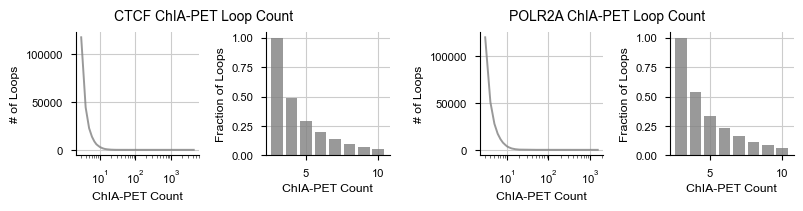

In [16]:
from utils.lines import chiapet_count_pl
fig = plt.figure(figsize=(8, 2))
sfig = fig.subfigures(1, 2)
chiapet_count_pl(ctcf_path, sfig[0])
sfig[0].suptitle("CTCF ChIA-PET Loop Count", fontsize=sf.settings.fontsize)
chiapet_count_pl(polr2a_path, sfig[1])
sfig[1].suptitle("POLR2A ChIA-PET Loop Count", fontsize=sf.settings.fontsize)
fig.savefig(os.path.join(out_dire, "s5a_chiapetcount.pdf"), bbox_inches="tight")

In [17]:
from utils.data import filter_chiapet
pet_paths = {"CTCF":{}, "POLR2A":{}}
for target in pet_paths:
    for min_count in [0, 5, 10]:
        fname = f"{target}_129S1SvImJ_25kb_min{min_count}.bedpe"
        pet_paths[target][min_count] = os.path.join(out_dire, fname)
        filter_chiapet(
            fish_path=fish_path, 
            chiapet_path=dtree["chiapet_mesc", target, "129S1/SvImJ"],
            out_path=pet_paths[target][min_count], min_count=min_count
        )

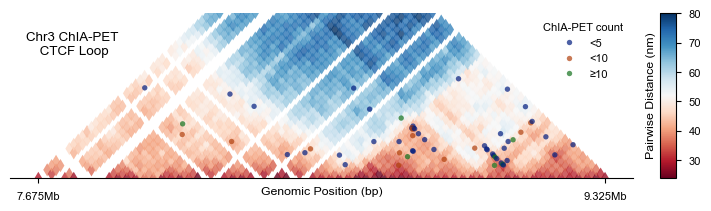

In [18]:
from utils.utils import chiapet_sub_df
chr_id, cut_lo, cut_hi = "chr3", 1e5, 1e6
adata = loader.create_adata(chr_id)
sub_df = chiapet_sub_df(chr_id, adata.var, ctcf_path, cut_lo, cut_hi)
med_dist = sf.pp.median_pdist(adata, inplace=False)

fig = plt.figure(figsize=(7, 2))
ax, cbar = sf.pl.triangle_heatmap(med_dist, adata.var, cut_hi=cut_hi, fig=fig)[1:]
cbar.set_label("Pairwise Distance (nm)", labelpad=-40)
df = sf.pl.rotate_df(sub_df)
df["cls"] = pd.cut(df["count"], bins=[0, 5, 10, 1e8], 
                   labels=["<5", "<10", "≥10"])
sns.scatterplot(df, x="x_rot", y="y_rot", marker="o", hue="cls", ax=ax, 
                palette="dark", linewidth=0, s=15, alpha=0.7)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-3:], labels[-3:], loc="upper right", 
          title="ChIA-PET count", title_fontsize=sf.settings.fontsize*.8)
ax.set_title(f"{chr_id.title()} ChIA-PET\n CTCF Loop", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "s5b_ctcf_chr3.pdf"), bbox_inches="tight")

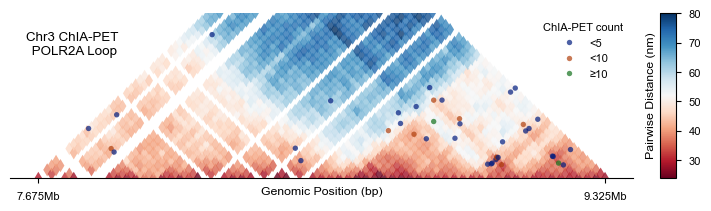

In [19]:
sub_df = chiapet_sub_df(chr_id, adata.var, polr2a_path, cut_lo, cut_hi)

fig = plt.figure(figsize=(7, 2))
ax, cbar = sf.pl.triangle_heatmap(med_dist, adata.var, cut_hi=cut_hi, fig=fig)[1:]
cbar.set_label("Pairwise Distance (nm)", labelpad=-40)
df = sf.pl.rotate_df(sub_df)
df["cls"] = pd.cut(df["count"], bins=[0, 5, 10, 1e8], 
                   labels=["<5", "<10", "≥10"])
sns.scatterplot(df, x="x_rot", y="y_rot", marker="o", hue="cls", ax=ax, 
                palette="dark", linewidth=0, s=15, alpha=0.7)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-3:], labels[-3:], loc="upper right", 
          title="ChIA-PET count", title_fontsize=sf.settings.fontsize*.8)
ax.set_title(f"{chr_id.title()} ChIA-PET\n POLR2A Loop", y=0.7, x=0.1)
fig.savefig(os.path.join(out_dire, "s5c_polr2a_chr3.pdf"), bbox_inches="tight")

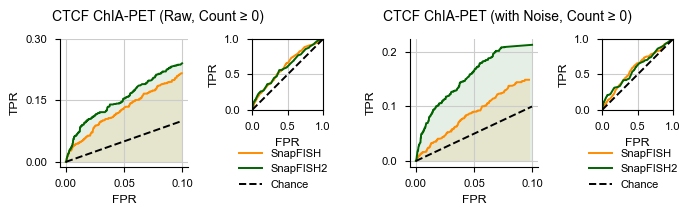

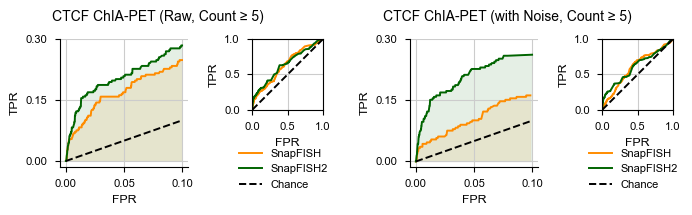

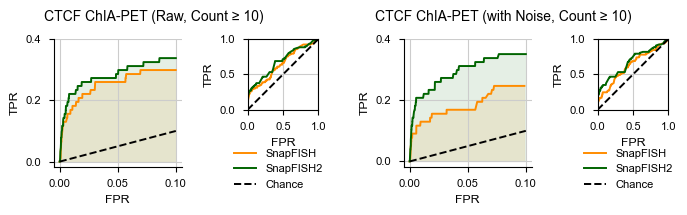

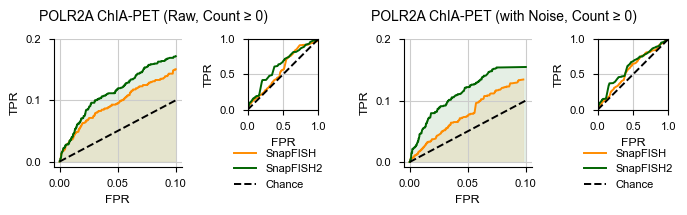

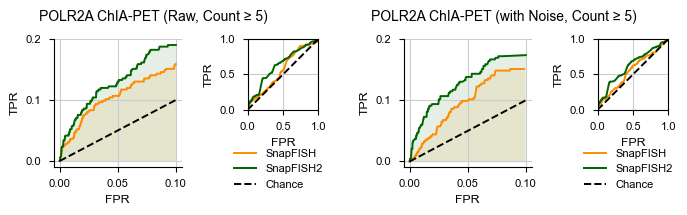

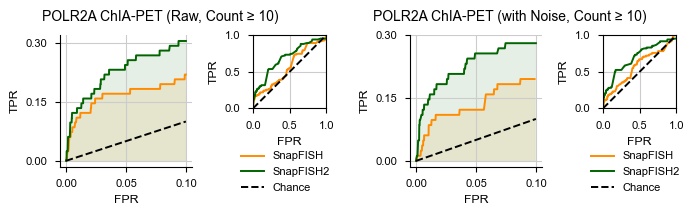

In [20]:
from utils.utils import create_roc_df
from utils.lines import roc_curve_pl
for target, v1 in pet_paths.items():
    for k, v in v1.items():
        fig = plt.figure(figsize=(7, 2))
        sfig = fig.subfigures(1, 2)
        roc_df = create_roc_df(v, res_sf1, res_sf2)
        roc_curve_pl(roc_df, sfig[0], f"{target} ChIA-PET (Raw, Count ≥ {k})")
        roc_df = create_roc_df(v, res_sf1_noised, res_sf2_noised)
        roc_curve_pl(roc_df, sfig[1], f"{target} ChIA-PET (with Noise, Count ≥ {k})")
        fig.savefig(os.path.join(out_dire, f"2c_roc_{target}_{k}.pdf"), bbox_inches="tight")

## FitHiC2 and HiCCUPS

Benchmark data: mESC from Bonev et al

FitHiC2: 4DNFI4OUMWZ8 (G0G1 phase cells and mESCs)

In [59]:
fithic2_path = os.path.join(out_dire, "fithic2.bedpe")
if not os.path.exists(fithic2_path):
    fit_fname = "../data/bonev_cell_2017/peaks_G0G1mESCs.bedpe"
    fdf = pd.read_csv(fit_fname, sep="\t", header=None, usecols=np.arange(6))
    fdf.columns = ["c1", "s1", "e1", "c2", "s2", "e2"]
    loop_len = fdf["s2"] - fdf["s1"]
    fdf = fdf[(loop_len >= 1e5)&(loop_len <= 1e6)]
    
    fithic2 = []
    for chr_id in loader.chr_ids:
        d1df = loader.create_adata(chr_id).var
        d1df["Chrom"] = chr_id
        cover_df = sf.tl.all_possible_pairs(d1df)
        df = sf.tl.loop_overlap(fdf[fdf["c1"]==chr_id], cover_df)
        fithic2.append(df[df["overlapped"]==3])
    fithic2 = pd.concat(fithic2, ignore_index=True)
    fithic2.to_csv(fithic2_path, sep="\t", index=False, header=False)
else:
    fithic2 = pd.read_csv(fithic2_path, sep="\t")
    fithic2.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "overlapped"]

`hicDetectLoops -m data/bonev_cell_2017/4DNFI4OUMWZ8_10kb.cool -o data/bonev_cell_2017/hicexplorer.bedgraph --maxLoopDistance 1000000 --windowSize 10 --peakWidth 6 --pValuePreselection 0.05 --pValue 0.05`

In [60]:
hicexpl_path = os.path.join(out_dire, "hicexpl.bedpe")
if not os.path.exists(hicexpl_path):
    exp_fname = "../data/bonev_cell_2017/hicexplorer.bedgraph"
    edf = pd.read_csv(exp_fname, sep="\t", header=None)
    edf.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "pval"]
    edf["c1"] = "chr" + edf["c1"].astype(str)
    edf["c2"] = "chr" + edf["c2"].astype(str)
    loop_len = edf["s2"] - edf["s1"]
    assert (loop_len > 0).all()
    edf = edf[(loop_len >= 1e5)&(loop_len <= 1e6)]
    
    hicexpl = []
    for chr_id in loader.chr_ids:
        d1df = loader.create_adata(chr_id).var
        d1df["Chrom"] = chr_id
        cover_df = sf.tl.all_possible_pairs(d1df)
        df = sf.tl.loop_overlap(edf[edf["c1"]==chr_id], cover_df)
        hicexpl.append(df[df["overlapped"]==3])
    hicexpl = pd.concat(hicexpl, ignore_index=True)
    hicexpl.to_csv(hicexpl_path, sep="\t", index=False, header=False)
else:
    hicexpl = pd.read_csv(hicexpl_path, sep="\t")
    hicexpl.columns = ["c1", "s1", "e1", "c2", "s2", "e2", "overlapped"]

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


0.46153846153846156

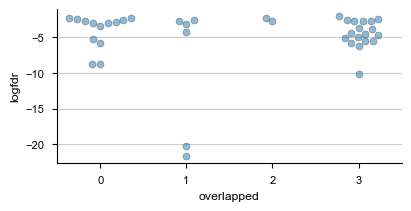

In [186]:
res_df = res_sf1[res_sf1["summit"]].copy()
res_df = res_df[res_df["fdr"] < 0.01]
res_df["overlapped"] = sf.tl.loop_overlap(res_df, fithic2)["overlapped"]
res_df["logfdr"] = np.log10(res_df["fdr"])
fig, ax = plt.subplots(figsize=(4, 2))
sns.swarmplot(res_df, x="overlapped", y="logfdr", linewidth=0.5, alpha=.5)
len(res_df[res_df["overlapped"]==3])/len(res_df)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


0.5625

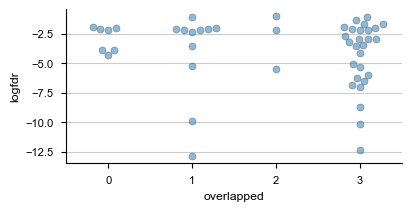

In [61]:
res_df = res_sf2[res_sf2["summit"]].copy()
res_df = res_df[res_df["pval"] < 1e-4]
# res_df = res_sf1[res_sf1["summit"]].copy()
res_df["overlapped"] = sf.tl.loop_overlap(
    res_df, fithic2, offset=25e3    
)["overlapped"]
res_df["logfdr"] = np.log10(res_df["fdr"])
fig, ax = plt.subplots(figsize=(4, 2))
sns.swarmplot(res_df, x="overlapped", y="logfdr", linewidth=0.5, alpha=.5)
len(res_df[res_df["overlapped"]==3])/len(res_df)

In [62]:
len(res_df[res_df["overlapped"]==3])

27

<Axes: xlabel='recall', ylabel='precisoin'>

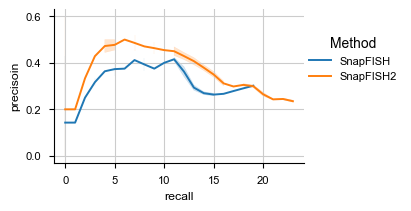

In [72]:
from sklearn.metrics import precision_recall_curve
plt_df = []
for i, res_sf in enumerate([res_sf1, res_sf2]):
    res_df = res_sf[res_sf["summit"]].copy()
    res_df["overlapped"] = sf.tl.loop_overlap(
        res_df, hicexpl, offset=25e3
    )["overlapped"]
    df = pd.DataFrame(np.stack(precision_recall_curve(
        res_df["overlapped"]==3, -res_df["pval"]
    )[:2]).T, columns=["precisoin", "recall"])
    # Display the actual number of overlapped loops
    df.recall *= np.sum(res_df["overlapped"]==3)
    df["Method"] = ["SnapFISH", "SnapFISH2"][i]
    plt_df.append(df)
plt_df = pd.concat(plt_df, ignore_index=True)
fig, ax = plt.subplots(figsize=(4, 2))
sns.lineplot(plt_df, x="recall", y="precisoin", hue="Method", ax=ax)

<Axes: xlabel='Genomic Position (bp)'>

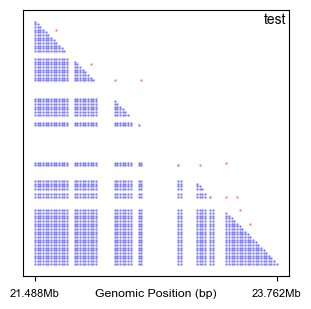

In [ ]:
df = true_df[true_df["c1"]=="chr13"]
df2 = res_sf1[res_sf1["c1"]=="chr13"]
ax = sf.pl.compare_loops(df2[df2.summit], df2, "test")
sns.scatterplot(df)

In [107]:
hic_dire = "../data/bonev_cell_2017/FitHiC_output_4DNFI3WPNFWT"
hic_fname = "FitHiC.spline_pass1.significances.rawcount.5.qval.0.01.txt"

hic_df = []
for c in list(range(1, 20)) + ["X"]:
    fname = os.path.join(hic_dire, f"chr{c}", hic_fname)
    hic_df.append(pd.read_csv(fname, sep="\t", header=None))
hic_df = pd.concat(hic_df, ignore_index=True)
hic_df.columns = [
    "c1", "m1", "c2", "m2", "contactCount", 
    "p-value", "q-value", "bias1", "bias2", "ExpCC"
]

# Ensure the first bin precedes the second bin
rf = hic_df["m1"] > hic_df["m2"]
m1 = hic_df.loc[rf, "m1"]
hic_df.loc[rf, "m1"] = hic_df.loc[rf, "m2"]
hic_df.loc[rf, "m2"] = m1

# Convert chromosome ID to "chrN"
hic_df["c1"] = "chr" + hic_df["c1"].astype(str)
hic_df["c2"] = "chr" + hic_df["c2"].astype(str)

# Add bin starting and ending positions
hic_df["s1"] = hic_df["m1"] - 5e3
hic_df["e1"] = hic_df["m1"] + 5e3
hic_df["s2"] = hic_df["m2"] - 5e3
hic_df["e2"] = hic_df["m2"] + 5e3

hic_df = hic_df[[
    "c1", "s1", "e1", "c2", "s2", "e2", "contactCount",
    "p-value", "q-value", "bias1", "bias2", "ExpCC"
]]

assert len(hic_df[hic_df["s1"] > hic_df["s2"]]) == 0, \
    "First bin should precede the second bin"

In [417]:
fithic2_path = "../data/bonev_2017/FitHiC_outputs"
f = "fithic_chrALL.spline_pass2.res10000.significances_PEAKS.txt.gz"
fithic2 = pd.read_csv(os.path.join(fithic2_path, f), sep="\t")
fithic2.rename(columns={"chr1":"c2", "chr2":"c1"}, inplace=True)
fithic2["c1"] = "chr" + fithic2["c1"].astype("str")
fithic2["c2"] = "chr" + fithic2["c2"].astype("str")
fithic2["s1"] = (fithic2["fragmentMid2"] - 5e3).astype("int64")
fithic2["e1"] = (fithic2["fragmentMid2"] + 5e3).astype("int64")
fithic2["s2"] = (fithic2["fragmentMid1"] - 5e3).astype("int64")
fithic2["e2"] = (fithic2["fragmentMid1"] + 5e3).astype("int64")
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]
fithic2 = fithic2[cols + fithic2.columns.drop(cols).tolist()]

from snapfish2.loop.func import all_possible_pairs
d1df = mfr.data[["Chrom", "Chrom_Start", "Chrom_End"]].drop_duplicates()
pairs = all_possible_pairs(d1df)
fithic2_df = loop_overlap(pairs, fithic2, offset=0)
fithic2_df["loop"] = fithic2_df["overlapped"] == 3

In [460]:
fithic2_merged = "../data/bonev_2017/FitHiC_filtered"
merged_fname = "merged_{}.spline_pass2.res10000.fdr{}.gz"

fdr = .0001
merged_fithic_loops = []
for i in range(1, 20):
    path = os.path.join(fithic2_merged, merged_fname.format(f"chr{i}", fdr))
    df = pd.read_csv(path, sep="\t").rename(columns={
        "chr1":"c1", "chr2":"c2", 
        "bin1_low":"s1", "bin1_high":"e1",
        "bin2_low":"s2", "bin2_high":"e2"
    })[["c1", "s1", "e1", "c2", "s2", "e2", "CC", "p", "fdr"]]
    d1df = mfr[f"chr{i}"][["Chrom", "Chrom_Start", "Chrom_End"]].drop_duplicates()
    pairs = all_possible_pairs(d1df)
    df = loop_overlap(pairs, df, offset=0)
    df["loop"] = df["overlapped"] == 3
    merged_fithic_loops.append(df)
merged_fithic_loops = pd.concat(merged_fithic_loops, ignore_index=True)
merged_fithic_loops[merged_fithic_loops.loop]

,c1,s1,e1,c2,s2,e2,overlapped,loop


[Text(0.5, 1.0, 'FitHiC Loops by FDR')]

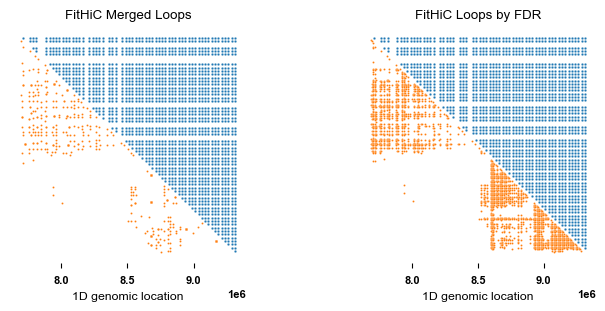

In [473]:
i = 3
fdr = .001
path = os.path.join(fithic2_merged, merged_fname.format(f"chr{i}", fdr))
df = pd.read_csv(path, sep="\t").rename(columns={
        "chr1":"c1", "chr2":"c2", 
        "bin1_low":"s1", "bin1_high":"e1",
        "bin2_low":"s2", "bin2_high":"e2"
    })[["c1", "s1", "e1", "c2", "s2", "e2", "CC", "p", "fdr"]]
d1df = mfr[f"chr{i}"][["Chrom", "Chrom_Start", "Chrom_End"]].drop_duplicates()
pairs = all_possible_pairs(d1df)
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
snapfish2.plot.compare_loops(pairs, df, "", "", ax=axes[0])
axes[0].set(title="FitHiC Merged Loops")

fdr_fname = "fithic_{}.spline_pass2.res10000.significances.txt.gz"
path = os.path.join(fithic2_merged, fdr_fname.format(f"chr{i}"))
df = pd.read_csv(path, sep="\t")
df.rename(columns={"chr1":"c2", "chr2":"c1"}, inplace=True)
df["c1"] = "chr" + df["c1"].astype("str")
df["c2"] = "chr" + df["c2"].astype("str")
df["s1"] = (df["fragmentMid2"] - 5e3).astype("int64")
df["e1"] = (df["fragmentMid2"] + 5e3).astype("int64")
df["s2"] = (df["fragmentMid1"] - 5e3).astype("int64")
df["e2"] = (df["fragmentMid1"] + 5e3).astype("int64")
df = df[df["q-value"] < fdr]

snapfish2.plot.compare_loops(pairs, df, "", "", ax=axes[1])
axes[1].set(title="FitHiC Loops by FDR")

In [73]:
old_dire = "../../SnapFISH-IMPUTE/figures/data_mESC_seqFISH"
old_fithic2 = pd.read_csv(os.path.join(old_dire, "fithic2_loops.txt"), sep="\t")
old_fithic2.rename(columns={
    "chr1":"c2", "chr2":"c1", "x1":"s1", "x2":"e1", "y1":"s2", "y2":"e2",
}, inplace=True)
old_fithic2["c1"] = "chr" + old_fithic2["c1"].astype("str")
old_fithic2["c2"] = "chr" + old_fithic2["c2"].astype("str")
old_fithic2["loop"] = True

In [74]:
old_fithic2

,c2,s1,e1,c1,s2,e2,resol,loop
0,chr1,136275000,136300000,chr1,136455000,136480000,10,True
1,chr1,136555000,136580000,chr1,136735000,136760000,10,True
2,chr1,136775000,136800000,chr1,137115000,137140000,10,True
3,chr10,75585000,75610000,chr10,75705000,75730000,10,True
4,chr10,75745000,75770000,chr10,75855000,75880000,10,True
...,...,...,...,...,...,...,...,...
97,chr9,119645000,119670000,chr9,119755000,119780000,10,True
98,chr9,120485000,120510000,chr9,121225000,121250000,10,True
99,chr9,120605000,120630000,chr9,120935000,120960000,10,True
100,chr9,120605000,120630000,chr9,121055000,121080000,10,True


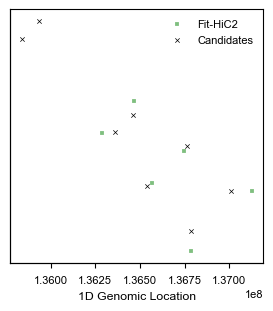

In [81]:
chr_id = "chr1"
# true_df = pd.read_csv(os.path.join(
#     chiapet_dire, fpath.format("ctcf", "intersection")
# ), sep="\t")
true_df = old_fithic2
df1 = true_df[true_df.loop]
df1 = df1[df1["c1"]==chr_id]
# df2 = res_sf2[res_sf2.fdr < 1e-2]
df2 = res_sf1[res_sf1["summit"]]
df2 = df2[df2["c1"]==chr_id]
eval_func = np.mean
map1, map2 = "Fit-HiC2", "Candidates"
ax = None

df1, df2 = df1.copy(), df2.copy()
df1["val1"] = eval_func(df1[["s1", "e1"]], axis=1)
df1["val2"] = eval_func(df1[["s2", "e2"]], axis=1)
df2["val1"] = eval_func(df2[["s1", "e1"]], axis=1)
df2["val2"] = eval_func(df2[["s2", "e2"]], axis=1)

if ax is None:
    fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(df1, x="val2", y="val1", s=10, color="green",
                marker="s", alpha=0.5, ax=ax, label=map1)
sns.scatterplot(df2, x="val1", y="val2", s=10, linewidths=.5,
                ax=ax, color="k", marker="x", label=map2)
sns.scatterplot(df1, x="val1", y="val2", s=10, color="green",
                marker="s", alpha=0.5, ax=ax)
sns.scatterplot(df2, x="val2", y="val1", s=10, linewidths=.5,
                ax=ax, color="k", marker="x")
ax.set(xlabel="1D Genomic Location", ylabel="", yticks=[])
ax.invert_yaxis()
ax2 = ax.twiny()
ax2.set(xlabel="", xticks=[], ylabel="")
ax.set_box_aspect(1)

ax.grid(False)
ax.spines[["top", "right"]].set_visible(True)
ax.legend(loc="best")

In [218]:
a = sf.tl.all_possible_pairs(d1df)
a = a[a["c1"]!="chrX"]
a["s2"] - a["s1"] > 0
a

,c1,s1,e1,c2,s2,e2
0,chr1,135625000,135650000,chr1,135650000,135675000
1,chr1,135625000,135650000,chr1,135700000,135725000
2,chr1,135625000,135650000,chr1,135725000,135750000
3,chr1,135625000,135650000,chr1,135775000,135800000
4,chr1,135625000,135650000,chr1,135825000,135850000
...,...,...,...,...,...,...
1765,chr19,14200000,14225000,chr19,13800000,13825000
1766,chr19,14200000,14225000,chr19,14600000,14625000
1767,chr19,14800000,14825000,chr19,13800000,13825000
1768,chr19,14800000,14825000,chr19,14600000,14625000
